# Tests de performance application IPS-rest et IPS-graphql

## Préparation : génération de la topologie

Fonctions de création de la topologie avec les APIs Rest et GraphQL :

In [1]:
import requests
from requests.auth import HTTPBasicAuth
import networkx as nx
import matplotlib.pyplot as plt
import time
import itertools
import random
import numpy as np

def create_graph_graphql(ip):
    # initialisation du graphe
    gr = nx.DiGraph()

    # requêtes au contrôleur ONOS
    url = "http://"+ip+":5000/graphql"
    liens_query = {'query': "query{liens{src,dst}}"}
    host_query = {'query': "query{hosts{id,locations}}"}
    r_hosts = requests.post(url, auth=HTTPBasicAuth('karaf','karaf'), data = host_query)
    r_links = requests.post(url, auth=HTTPBasicAuth('karaf','karaf'), data = liens_query)

    if (r_hosts.status_code != 200):
        return "Erreur sur la liste des hôtes."
    elif (r_links.status_code != 200):
        return "Erreur sur la liste des liens."
    else:
        global host_list_mac_gq
        host_list_mac_gq = []
        host_list = r_hosts.json()['data']['hosts']
        link_list = r_links.json()['data']['liens']
        
        for l in link_list:
            gr.add_edge(l['src']['device'],l['dst']['device'],orig=l['src']['port'],dest=l['dst']['port'])
            gr.add_edge(l['dst']['device'],l['src']['device'],orig=l['dst']['port'],dest=l['src']['port'])
        
        for h in host_list:
            gr.add_node(h['id'],id=h['id'])
            host_list_mac_gq.append(h['id'])
            gr.add_edge(h['id'],h['locations'][0]["elementId"],orig="host",dest=h['locations'][0]["port"])
            gr.add_edge(h['locations'][0]["elementId"],h['id'],orig=h['locations'][0]["port"],dest="host")
        
        return gr
    
def create_graph_rest(ip):
    # initialisation du graphe
    gr = nx.DiGraph()

    # requêtes au contrôleur ONOS
    r_host = requests.get("http://"+ip+":5000/hosts", auth=HTTPBasicAuth('karaf','karaf'))
    r_link = requests.get("http://"+ip+":5000/links", auth=HTTPBasicAuth('karaf','karaf'))
    if (r_host.status_code != 200):
        return "Erreur sur la liste des hôtes."
    elif (r_link.status_code != 200):
        return "Erreur sur la liste des liens."
    else:
        global host_list_mac_re
        host_list_mac_re = []
        host_list = r_host.json()
        link_list = r_link.json()
        
        for l in link_list:
            gr.add_edge(l['src']['device'],l['dst']['device'],orig=l['src']['port'],dest=l['dst']['port'])
            gr.add_edge(l['dst']['device'],l['src']['device'],orig=l['dst']['port'],dest=l['src']['port'])
        
        for h in host_list:
            gr.add_node(h['id'],id=h['id'])
            host_list_mac_re.append(h['id'])
            gr.add_edge(h['id'],h['locations'][0]["elementId"],orig="host",dest=h['locations'][0]["port"])
            gr.add_edge(h['locations'][0]["elementId"],h['id'],orig=h['locations'][0]["port"],dest="host")
        
        return gr

gr_rest = create_graph_rest("192.168.1.154")
gr_graphql = create_graph_graphql("192.168.1.154")

## Test 1 : topologie mininet torus,4,4 - 16 hôtes, 64 liens

- on sélectionne au hasard un nombre N de couples d'hôtes à relier
- on installe les intents nécessaires au bon routage des paquets

On génère tout d'abord une liste de 5, 20 et 50 couples d'hôtes à relier :

In [2]:
liste_couples = list(itertools.combinations(host_list_mac_re, 2))

liste_res = []
for i in range(1,11):
    liste_res.append(random.choices(liste_couples, k=12*i))

Pour chaque couple d'hôtes, on installe les intents :

In [3]:
def install_intent_re(mac_o,mac_d,liste_chemin):
    l=liste_chemin
    fwd_orig = ("","")
    fwd_dest = ("","")
    mac_orig = mac_o.replace("/None","")
    mac_dest = mac_d.replace("/None","")
    for i in range(0,len(l)-1):
        if i==len(l)-2:
            port = gr_rest.get_edge_data(l[i],l[i+1])
            fwd_dest = (l[i],port["orig"])
            intent_orig = fwd_orig[0]+"-"+fwd_orig[1]
            intent_dest = fwd_dest[0]+"-"+fwd_dest[1]
            r_intent = requests.get("http://192.168.1.154:5000/intent?orig="+intent_orig+"&dest="+intent_dest
            +"&macorig="+mac_orig+"&macdest="+mac_dest)
            r_intent_inv = requests.get("http://192.168.1.154:5000/intent?orig="+intent_dest+"&dest="+intent_orig
            +"&macorig="+mac_dest+"&macdest="+mac_orig)
        else:
            port = gr_rest.get_edge_data(l[i],l[i+1])
            if (port["orig"]=="host"):
                fwd_orig = (l[i+1],port["dest"])
            else:
                fwd_dest = (l[i],port["orig"])
                if (port["orig"]!="host"):
                    intent_orig = fwd_orig[0]+"-"+fwd_orig[1]
                    intent_dest = fwd_dest[0]+"-"+fwd_dest[1]
                    r_intent = requests.get("http://192.168.1.154:5000/intent?orig="+intent_orig+"&dest="+intent_dest
                    +"&macorig="+mac_orig+"&macdest="+mac_dest)
                    r_intent_inv = requests.get("http://192.168.1.154:5000/intent?orig="+intent_dest+"&dest="+intent_orig
            +"&macorig="+mac_dest+"&macdest="+mac_orig)

                    fwd_orig = (l[i+1],port["dest"])
                else:
                    fwd_orig = ("","")
    return "ok"

def install_intent_gq(mac_o,mac_d,liste_chemin):
    l=liste_chemin
    fwd_orig = ("","")
    fwd_dest = ("","")
    mac_orig = mac_o.replace("/None","")
    mac_dest = mac_d.replace("/None","")
    string_mut="mutation { \n"
        

    for i in range(0,len(l)-1):
        if i==len(l)-2:
            port = gr_graphql.get_edge_data(l[i],l[i+1])
            fwd_dest = (l[i],port["orig"])
            intent_orig = fwd_orig[0]+"/"+fwd_orig[1]
            intent_dest = fwd_dest[0]+"/"+fwd_dest[1]
            string_mut += "r"+str(i)+": addIntent(intent_orig: \""+intent_orig+"\", mac_orig: \""+mac_orig+"\", intent_dest: \""+intent_dest+"\", mac_dest: \""+mac_dest+"\") { intent_orig, intent_dest }\n"
            string_mut += "s"+str(i)+": addIntent(intent_orig: \""+intent_dest+"\", mac_orig: \""+mac_dest+"\", intent_dest: \""+intent_orig+"\", mac_dest: \""+mac_orig+"\") { intent_orig, intent_dest }\n"
        else:
            port = gr_graphql.get_edge_data(l[i],l[i+1])
            if (port["orig"]=="host"):
                fwd_orig = (l[i+1],port["dest"])
            else:
                fwd_dest = (l[i],port["orig"])
                if (port["orig"]!="host"):
                    intent_orig = fwd_orig[0]+"/"+fwd_orig[1]
                    intent_dest = fwd_dest[0]+"/"+fwd_dest[1]

                    string_mut += "r"+str(i)+": addIntent(intent_orig: \""+intent_orig+"\", mac_orig: \""+mac_orig+"\", intent_dest: \""+intent_dest+"\", mac_dest: \""+mac_dest+"\") { intent_orig, intent_dest }\n"
                    string_mut += "s"+str(i)+": addIntent(intent_orig: \""+intent_dest+"\", mac_orig: \""+mac_dest+"\", intent_dest: \""+intent_orig+"\", mac_dest: \""+mac_orig+"\") { intent_orig, intent_dest }\n"

                    fwd_orig = (l[i+1],port["dest"])
                else:
                    fwd_orig = ("","")

    string_mut += "}"
    mutation_query = {'query': string_mut}
    query_gql = requests.post("http://192.168.1.154:5000/graphql", auth=HTTPBasicAuth('karaf','karaf'), data = mutation_query)
    return "ok"

temps_re = []
temps_gq = []
for i in liste_res:
    start = time.time()
    for elt in i:
        # clean = requests.get("http://192.168.1.154:5000/removeIntents")
        install_intent_re(elt[0],elt[1],nx.shortest_path(gr_rest,elt[0],elt[1]))
    end = time.time()
    temps_re.append(round(end-start,1))

for i in liste_res:
    start = time.time()
    for elt in i:
        # clean = requests.get("http://192.168.1.154:5000/removeIntents")
        install_intent_gq(elt[0],elt[1],nx.shortest_path(gr_graphql,elt[0],elt[1]))
    end = time.time()
    temps_gq.append(round(end-start,1))

print(temps_re)
print(temps_gq)

[6.4, 15.2, 24.9, 31.9, 39.6, 48.5, 57.2, 65.0, 73.3, 79.2]
[5.4, 12.1, 18.4, 24.7, 30.9, 36.9, 41.5, 47.5, 54.4, 59.7]


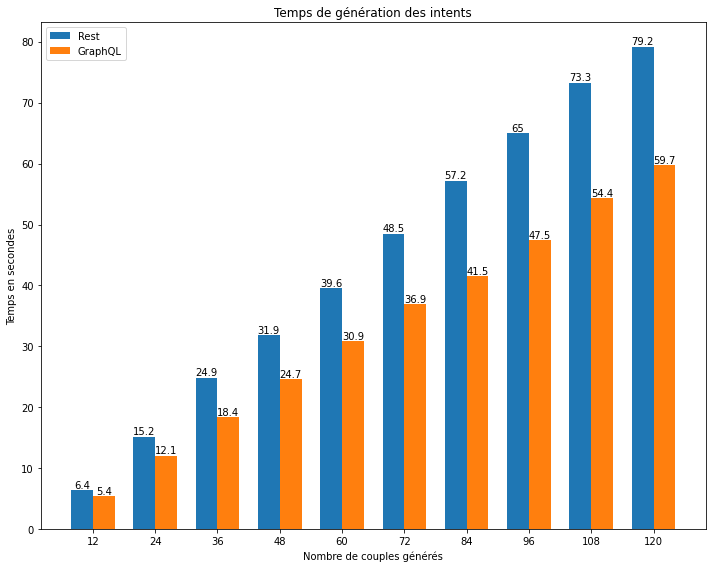

In [14]:
labels = []
for i in range(1,11):
    labels.append(str(12*i))

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10,8))
rects1 = ax.bar(x - width/2, temps_re, width, label='Rest')
rects2 = ax.bar(x + width/2, temps_gq, width, label='GraphQL')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Nombre de couples générés')
ax.set_ylabel('Temps en secondes')
ax.set_title('Temps de génération des intents')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1)
ax.bar_label(rects2)

fig.tight_layout()

plt.show()